# Detekce anomálií v datech o znečištění ovzduší

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pandas.plotting import scatter_matrix
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler


from lampy import data
from lampy import metrics
from lampy import plot
from lampy.lstm import LSTM

## Explorace

### Datové zdroje

V [katalogu datové platformy Golemio](https://golemio.cz/cs/node/622) jsou k dispozici dva datové CSV soubory:
jeden za druhé pololetí roku 2018 a druhý za zatím uplynulou část prvního pololetí roku 2019. Data z druhé poloviny obsahují celkem 473529 záznamů z toho jsou ale dostupné odečty PM<sub>10</sub> pouze v 129807 případech. V soubory z roku 2019 je zatím celkem 226672 záznamů a z toho 62518 měření PM<sub>10</sub>.

In [2]:
data_file_2018 = 'data/636f6a2e-3a48-4801-afce-05c864adc60e-lampy_2019.csv'
data_2018 = pd.read_csv(data_file_2018, index_col='sid', sep=';', parse_dates=['starttimestamp'])
data_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473529 entries, 24a5mhj5yiqqhmtxzvsztbwxoduhdzyd to y7e4onsytkb3ydonflz5kcbcigkh5ulo
Data columns (total 8 columns):
starttimestamp              473529 non-null datetime64[ns, UTC]
geocoordinates_latitude     473505 non-null float64
geocoordinates_longitude    473505 non-null float64
o3                          407537 non-null float64
pm2p5                       129807 non-null float64
no2                         407537 non-null float64
so2                         407537 non-null float64
pm10                        129807 non-null float64
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 32.5+ MB


In [3]:
data_file_2019 = 'data/2e6bbd16-8d1c-4efa-b0f0-06a74f40d8d3-lampysensory-2019-1pololeti.csv'
data_2019 = pd.read_csv(data_file_2019, index_col='sid', parse_dates=['starttimestamp'])
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226672 entries, 6aivodbkkk3xlwbjlkerclrnk4gtfy3x to oowrrh4zfxs66zdreivyrri2ribhexgc
Data columns (total 8 columns):
starttimestamp              226672 non-null datetime64[ns, UTC]
geocoordinates_latitude     226672 non-null float64
geocoordinates_longitude    226672 non-null float64
o3                          196871 non-null float64
pm2p5                       62518 non-null float64
no2                         196871 non-null float64
so2                         196871 non-null float64
pm10                        62518 non-null float64
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 15.6+ MB


Každý záznam se skládá z následujích atributů:

- `sid` (string): identifikátor stanice;
- `starttimestamp` (datetime): datum a čas měření,
- `o3` (integer with precision): atribut O<sub>3</sub> (ozon, ppb),
- `no2` (integer with precision): atribut NO<sub>2</sub> (oxid dusičitý, ppb),
- `so2` (integer with precision): atribut SO<sub>2</sub> (oxid siřičitý, ppb),
- `pm10` (integer with precision): atribut jemné částice PM<sub>10</sub> (µg m<sup>-3</sup>),
- `pm2p5` (integer with precision): atribut jemné částice PM<sub>2,5</sub> (µg m<sup>-3</sup>),
- `geocoordinates_latitude` (integer with precision): zeměpisná šířka stanice,
- `geocoordinates_longitude` (integer with precision): zeměpisná délka stanice,

kde ppb znamená [parts per bilion](https://en.wikipedia.org/wiki/Parts-per_notation). Datová sada by měla obsahovat odečty z 43 senzorů, které jsou rozmístěny na vybraných lampách, ale ve skutečnosti jsou k dispozici data pouze z 22 senzorů.

In [4]:
sids = data_2018.index.unique()
print('počet senzorů:', len(sids))

počet senzorů: 22


Ze 22 senzorů měří podle dostupných dat polétavý prach PM<sub>10</sub> pouze 6 senzorů z nich nejvíce měření má stanice s identifikátorem: `y7e4onsytkb3ydonflz5kcbcigkh5ulo`.

In [5]:
target = 'pm10'
value_counts = data_2018[target].dropna().index.value_counts()
sid = value_counts.index[0]
value_counts

y7e4onsytkb3ydonflz5kcbcigkh5ulo    32872
heql54pdiq6xb6j74qdpnlovm77jaify    24548
6czebgzn24hwd3vpklvuphomcfcwpqgx    24100
xct4lqv4q3ht3a7peubhfnyyhbsnno7g    17447
bxjhuifodo6nf7bnstd55g3mzw6wfv7c    17078
gdyaoaed7gnarg6kqk2o6bmsjrw6wlk5    13762
Name: sid, dtype: int64

### Trénovací a testovací data

Vezmeme-li si pouze data z této lampy a ponecháme si atributy `o3`, `pm2p5`, `no2`, `so2` a `pm10`, tak dostaneme data dimenze 5, kterí obsahují 32872 záznamů v roce 2018 a 12709 záznamů v roce 2019, a to je dohromady 45581 záznamů za oba roky. Protože pracujeme s časovou řadou jako index zachováme datum a čas měření tedy `starttimestamp`.

Dále se přímo nabízí rozdělit data na trénovací a testovací množinu podle roku měření tj. podle souborů. Takové rozdělení má 72,1% dat v trénovací množině a 27,9% dat v množině testovací.

In [6]:
features = ['o3', 'pm2p5', 'no2', 'so2', 'pm10']

In [7]:
train_data = data_2018.loc[sid].set_index('starttimestamp')[features].sort_index()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32872 entries, 2018-07-05 11:52:18+00:00 to 2018-12-31 23:53:11+00:00
Data columns (total 5 columns):
o3       32872 non-null float64
pm2p5    32872 non-null float64
no2      32872 non-null float64
so2      32872 non-null float64
pm10     32872 non-null float64
dtypes: float64(5)
memory usage: 1.5 MB


In [8]:
test_data = data_2019.loc[sid].set_index('starttimestamp')[features].sort_index()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12709 entries, 2019-01-01 00:03:11+00:00 to 2019-04-04 15:23:07+00:00
Data columns (total 5 columns):
o3       12709 non-null float64
pm2p5    12709 non-null float64
no2      12709 non-null float64
so2      12709 non-null float64
pm10     12709 non-null float64
dtypes: float64(5)
memory usage: 595.7 KB


In [9]:
n_train = train_data.shape[0]
n_test = test_data.shape[0]
n_data = n_train + n_test
print('celkem záznamů:', n_data)
print('trénovacích záznamů: {} ({:.1f}%)'.format(n_train, 100 * n_train / n_data))
print('testovacích záznamů: {} ({:.1f}%)'.format(n_test, 100 * n_test / n_data))

celkem záznamů: 45581
trénovacích záznamů: 32872 (72.1%)
testovacích záznamů: 12709 (27.9%)


### Vizualizace

Základní vizualizace časové řady ukazuje, že v datech o polétavém prachu opravdu nějaké anomálie jsou. Dále je vidět, že data na první pohled neobsahují žádné známky sezóního chování.

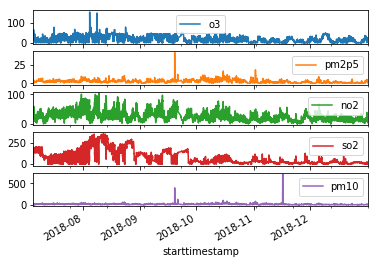

In [10]:
train_data.plot(subplots=True)
plt.savefig('img/data_preview.svg')

Boxplot ukazuje že z hlediska absolutní velikosti hodnoty PM<sub>10</sub> mnoho bodů vybočuje od průměru 14.093698, který má relativně malou standarní odchylku 18.931824. Samozřejmě všechny tyto body nemusí být anomálie, protože naše detekce je časově závislá a záleží na předchozích měřeních.

count    32872.000000
mean        14.093698
std         18.931824
min          1.000000
25%          6.000000
50%         11.430000
75%         18.650000
max        718.900000
Name: pm10, dtype: float64

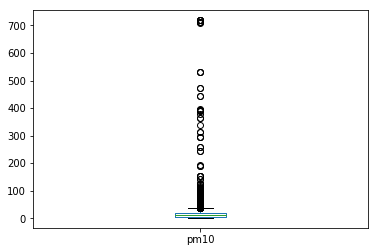

In [11]:
train_data['pm10'].plot.box()
plt.savefig('img/boxplot.svg')
train_data['pm10'].describe()

Jistou lineární závislost naznačuje tak zvaný *lag plot*, který zobrazuje závíslost měření na měřením předchozím, body se totiž shormaždují na diagonále. I zde je vidět zhruba 6 anomálních měření, která leží mimo diagonálu.

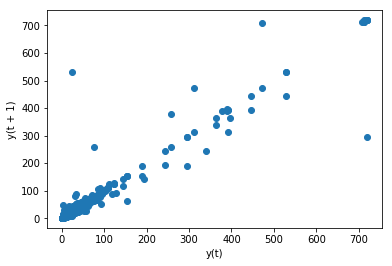

In [12]:
lag_plot(train_data['pm10'])
plt.savefig('img/lag_plot.svg')

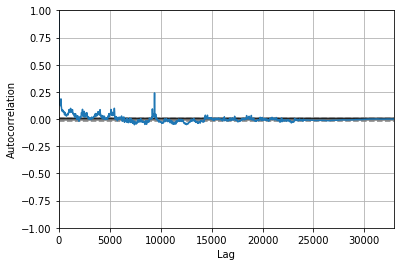

In [13]:
autocorrelation_plot(train_data['pm10'])
plt.savefig('img/autocorrelation_plot.svg')

Poslední vizualizační pomůckou, kterou prozkoumáváme data je korelační graf. Zajímá nás především korelace příznaku `pm10` s ostaními. Za povšimnutí stojí, že anomálie PM<sub>10</sub> se vyskutují pouze pokud je nízká hladina SO<sub>2</sub> a O<sub>3</sub>.

Každopádně tento vztah zřejmě není lineární, protože korelační koeficient je v obou případech blízký nule (0.028117 resp. -0.067698) v porovnání s největším korelační koeficient, který má s příznakem `pm2p5`, a to 0.530632. Z korelačního grafu PM<sub>10</sub> a PM<sub>2,5</sub> je ale vidět, že nekteré anomáli nastávají jak při zvyšené hladině PM<sub>2,5</sub> tak při jejím normálním stavu.

,o3,pm2p5,no2,so2,pm10
o3,1.000000,-0.056971,-0.034901,0.344683,-0.067698
pm2p5,-0.056971,1.000000,0.501517,0.017095,0.530632
no2,-0.034901,0.501517,1.000000,0.090230,0.320133
so2,0.344683,0.017095,0.090230,1.000000,0.028117
pm10,-0.067698,0.530632,0.320133,0.028117,1.000000


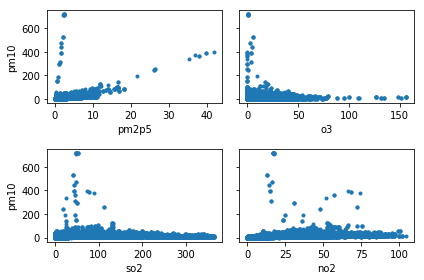

In [14]:
fig, axs = plt.subplots(2, 2, sharey=True)
axs[0, 0].set_ylabel('pm10')
axs[1, 0].set_ylabel('pm10')
for ax, col in zip(axs.ravel(), ['pm2p5', 'o3', 'so2', 'no2']):
    ax.plot(train_data[col], train_data['pm10'], '.')
    ax.set_xlabel(col)
fig.tight_layout()
plt.savefig('img/scatter_plot.svg')
train_data.corr()

### Rozdíl časů odečtů

Podle specifikace je vyčítací frekvence 15 minut z brány do platformy. Naše data takovéto pravidelné intervaly neobsahují. Průměrně je dostupné nové měření asi každých 7 minut a 52 sekund se standarní odchylkou zhruba 18 minut a 20 sekund.

Zřejmé výpadky ale mohou systém odstavit i na delší dobu. V našich datech je nejdelší prodleva přes 1 den a 15 hodin.

In [15]:
time_delta = pd.Series(train_data.index[1:] - train_data.index[:-1])
time_delta_mean = time_delta.mean()
time_delta_std = time_delta.std()
time_delta_mean, time_delta_std

(Timedelta('0 days 00:07:51.809588'), Timedelta('0 days 00:18:20.667901'))

In [16]:
time_delta.max()

Timedelta('1 days 15:36:51')

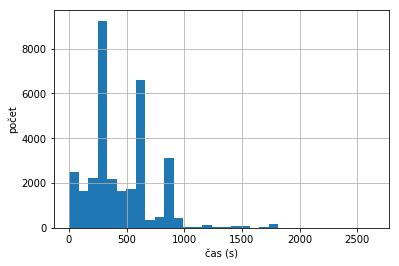

In [17]:
ax = time_delta[time_delta < time_delta_mean + 2 * time_delta_std].dt.total_seconds().hist(bins=32)
ax.set_xlabel('čas (s)')
ax.set_ylabel('počet')
plt.savefig('img/cas_odectu.svg')

### Log–log plot

Poslední vizualizační pomůckou, která nám pomůže nahlédnou do dat z hlediska jejich absolutní velikosti je tzv. log–log graf. Především v jeho pravé dolní části je vidět, že data obsahují něktré abnormálně velké hodnoty a bude úkolem námi naučených klasifikátorů tyto hodnoty najít i vzhledem k časové závislosti na bodech předchozích.

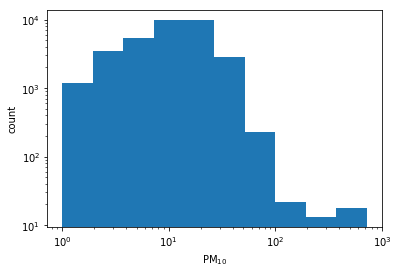

In [18]:
pm10 = train_data['pm10'].values
ax = plt.axes(xlabel='PM$_{10}$', ylabel='count')
bins = np.logspace(np.log10(pm10.min()), np.log10(pm10.max()), num=11)
ax.hist(pm10, bins, log=True)
ax.set_xscale('log')
plt.savefig('img/log-log_plot.svg')

## Předzpracování

Původní data tedy nejsou samplovány v rovnoměrných intervalech, a proto je v rámci předzpracování přesamplujeme na každých 15 minut, což je vyčítací frekvence z platformy a k doplnění chybějících hodnot použijeme metodu *fill forward*, která doplní vždy předchozí hodnotu.

Data musí přetransformovat do podoby vhodné pro předpovídání časových řad, abychom potom mohli detekovat anomálie. To znamená že z měření v čase $t$ se budeme snažit předpovědět hodnotu `pm10` v čase $t + 1$.

Poté data rozdělíme na trénovací a validační množinu. Validační množina nám poslouží k výběru modelu a jeho hyperparametrů. Konzervativně jsem se rozhodnul, že data rozdělím na půlky tak, aby odhad byl co nejpřesnější. 

Nakonec aby různé příznaky byly zhruba stejných rozsahů použijeme standadrní škálování, takže každý příznak má trénovací množiny bude mít nulový průměr a jenotkovou standardní odchylku. Takto předzpracovaná data nám umožní i správnou selekci příznaků pomocí linearní regrese s L1 regularizací.

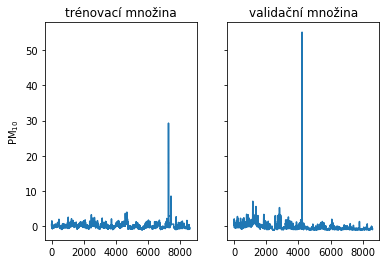

In [19]:
resampled_train_data = data.resample_data(train_data, period='15T')
X, y = data.create_dataset(resampled_train_data)

X_tr_raw, X_val_raw, y_tr_raw, y_val_raw = data.train_validation_split(X, y)

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_tr_all = X_scaler.fit_transform(X_tr_raw)
y_tr = y_scaler.fit_transform(y_tr_raw)

X_val_all = X_scaler.transform(X_val_raw)
y_val = y_scaler.transform(y_val_raw)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(y_tr)
ax1.set_ylabel('$\mathrm{PM}_{10}$')
ax1.set_title('trénovací množina')
ax2.plot(y_val)
ax2.set_title('validační množina')
plt.savefig('img/train_validation_split.svg')

## Selekce příznaků

Selekce podmnožiny příznaků může být důležitá například pro snížení komunikační zátěže. Vhodné příznaky pro linearní modely můžeme vybrat napříkad pomocí linearní regrese s L1 regularizací (Lasso). Ta totiž koeficienty u nevhodný příznaků drží blízko nule.

Z výše zmíněných důvodů jsem zkusil natrénovat Lasso pro 23 různých hodnot regularizačního parametru na logaritmické škále mezi 10<sup>-10</sup> a 10<sup>1</sup>. Výsledné grafy jasně ukazují, že důležitý je pouze příznak `pm10`, protože ostatní jsou blízké nule, pokud jekvadratická odmocnina ze střední kvadratická odchylka nízká. Pro testované lineární modely stačí tedy uvažovat pouze tento příznak.

,RMSE,koeficient o3,koeficient pm2p5,koeficient no2,koeficient so2,koeficient pm10
alpha,,,,,,
1.000000e-10,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-10,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
1.000000e-09,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-09,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
1.000000e-08,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-08,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
1.000000e-07,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-07,0.638710,-0.016697,0.001962,0.019412,0.011029,0.947370
1.000000e-06,0.638710,-0.016697,0.001963,0.019412,0.011028,0.947369


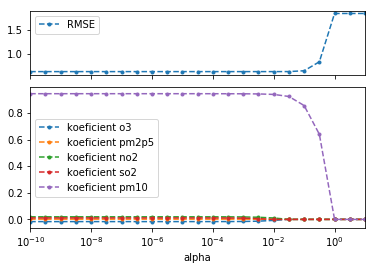

In [20]:
n_features = X_tr_all.shape[1]
columns = ['RMSE'] + ['koeficient ' + feature for feature in features]

n_alphas = 23
alphas = np.logspace(-10, 1, n_alphas)
lasso_stats = pd.DataFrame(index=alphas, columns=columns, dtype=np.float)
lasso_stats.index.name = 'alpha'

for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha)
    lasso.fit(X_tr_all, y_tr)

    y_pred = lasso.predict(X_val_all)
    
    lasso_rmse = metrics.rmse(y_val, y_pred)
    lasso_stats.loc[alpha] = (lasso_rmse, *lasso.coef_)

fig = plt.figure()
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1:, :])
lasso_stats.plot(ax=ax1, y='RMSE', logx=True, style='.--')
ax1.set_xlabel('')
ax1.set_xticklabels([])
lasso_stats.plot(ax=ax2, y=columns[1:], logx=True, style='.--')
plt.savefig('img/feature_selection.svg')
lasso_stats

In [21]:
target_index = np.where(train_data.columns == 'pm10')[0][0]
X_tr = X_scaler.fit_transform(X_tr_raw[:, [target_index]])
X_val = X_scaler.transform(X_val_raw[:, [target_index]])

## Porovnání modelů

Problém je definovám tak, že předpovíme pomocí nějakého algoritmu strojové učení následují hodnotu, která by měla následovat po jich zaznamenaných měření. Předpovězenou hodnotu potom porovnáme s naměřenou hodnotou a pokud se tyto hodnoty nepřirozeně liší, tak měření označíme jako anomálii.

Jako vhodné algoritmy jsem zvolil tři základní:

- základní model, který předpokládá že následující hodnota měření bude stejná jako přechozí,
- lineární regresní model a
- rekurentní neuronovou síť (konkrétně dnes nejpopulárnější Long Short-Term Memory).

Abych mohl modely mezi sebou porovnávat je potřeba zvolit nějakou metriku. Pro regresní problémy je nejpřirozenější odmocnina ze střední kvadratické chyby:

$$\mathrm{RMSE} = \sqrt{\frac{1}{N} \sum^{N}_{i = 1}(\hat{y_i} - y_i)^2},$$

kde $N$ je počet měření, $\hat{y_i}$ je predikce modelu a $y_i$ je skutečně naměřená hodnota.

### Základní model

Základní model nám poskytny odrazový můstek, ke kterému budeme moci vztahovat výsledky ostatních modelů. Navíc je jednoduchý na implementaci a dosahuje výsledku vypsaného níže.

In [22]:
y_pred = X_val
baseline_rmse = metrics.rmse(y_val, y_pred)
print('RMSE základního modelu:', baseline_rmse)

RMSE základního modelu: 0.6492021924513823


### Linearní regrese

Druhým modelem je linearní regrese a nyní už bez regularizace, protože nám zůstal pouze jeden příznak. Pokud necháme tento model předpovídat pouze z bezprostředně předcházející hodnoty dostaneme RMSE viz níže.

In [23]:
linear_predictor = linear_model.LinearRegression()
linear_predictor.fit(X_tr, y_tr)

y_pred = linear_predictor.predict(X_val)

linear_rmse = metrics.rmse(y_val, y_pred)
print('RMSE lineární regrese:', linear_rmse)

RMSE lineární regrese: 0.6401653966120437


Můžeme ale také nechat linearní regresi předpovídat z hodnot větší historie. Graf níže ukazuje výsledek pro velikosti hisotrie 1 až 100. Jako nejlepší se ukazuje velikost historie hodnoty 2, kde je RMSE rovna 0.63797. Následně se RMSE zhorší a poté konverguje k hodnotě zhruba 0,71.

,RMSE
okno,
2,0.63797


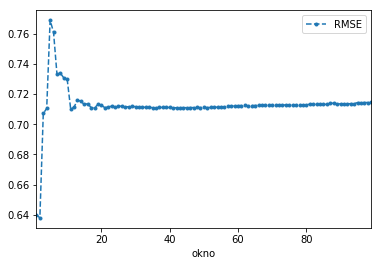

In [24]:
windows = list(range(1, 100))
linear_stats = pd.DataFrame(index=windows, columns=['RMSE'],
                            dtype=np.float)
linear_stats.index.name = 'okno'

for window in windows:
    X_tr_trans, y_tr_trans = data.transform_dataset(X_tr, y_tr, window)
    X_val_trans, y_val_trans = data.transform_dataset(X_val, y_val, window)

    linear = linear_model.LinearRegression()
    linear.fit(X_tr_trans, y_tr_trans)

    y_pred = linear.predict(X_val_trans)
    linear_stats.loc[window] = metrics.rmse(y_val_trans, y_pred)

linear_stats.plot(style='.--')
plt.savefig('img/linear_regresion_window.svg')
best_window = linear_stats['RMSE'].idxmin()
best_linear_rmse = linear_stats.loc[best_window, 'RMSE']
linear_stats.loc[[best_window]]

### Long Short-Term Memory (LSTM) rekurentní neuronová síť

Poslední a nejkomplexnější model je [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/), který dokáže zachytit i nelineární vztahy v datech, a proto vstupu tohoto modelu všechny příznaky.

Jako architekturu jsou zvolil jednovrstvout rekuretní síť s velikostí skrytého stavu 64. Výstupem ale musí být pouze jedno číslo které predikuje měření PM<sub>10</sub>. Proto je na vlastní buňce LSTM ještě linearní vrstva, která produkuje onu jednu výstupní hodnotu.

Co se týče trénování, LSTM jsem trénoval na sekvencích délky 100 a celkem 50 epoch. Výsledné RMSE na validační setu viz níže.

epoch: 1 train loss: 0.6383749063095933 validation loss: 2.461705058176648
epoch: 2 train loss: 0.5052041409895023 validation loss: 2.297371668625232
epoch: 3 train loss: 0.42520085509544325 validation loss: 2.153636539214833
epoch: 4 train loss: 0.3642510864107469 validation loss: 2.0541466276404363
epoch: 5 train loss: 0.32276789251016585 validation loss: 1.9808677170380686
epoch: 6 train loss: 0.29312838956506115 validation loss: 1.9189754617136723
epoch: 7 train loss: 0.2713386432402856 validation loss: 1.8697165203183033
epoch: 8 train loss: 0.2558267183783878 validation loss: 1.8148476716646356
epoch: 9 train loss: 0.2411487673669275 validation loss: 1.7613883554215994
epoch: 10 train loss: 0.2285481484670644 validation loss: 1.7120533609345985
epoch: 11 train loss: 0.21853341726295422 validation loss: 1.6982630425951717
epoch: 12 train loss: 0.207681311585267 validation loss: 1.663580679295787
epoch: 13 train loss: 0.2010093624370083 validation loss: 1.6244119769904828
epoch: 14

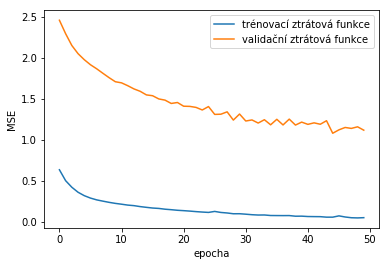

In [25]:
lstm = LSTM(input_size=5, hidden_size=64, output_size=1)
lstm_stats = lstm.train(X_tr_all, y_tr, X_val_all, y_val,
                        n_epochs=50, seq_len=100)

ax = plt.axes()
ax.plot(lstm_stats['tr_losses'], label='trénovací ztrátová funkce')
ax.plot(lstm_stats['val_losses'], label='validační ztrátová funkce')
ax.set_xlabel('epocha')
ax.set_ylabel('MSE')
ax.legend()
plt.savefig('img/losses.svg')

y_pred = lstm.predict(X_val_all)
lstm_rmse = metrics.rmse(y_val, y_pred)
print('RMSE LSTM:', lstm_rmse)

### Výsledky

Níže jsou porovnány RMSE všech čtyř různých přístupů k předpovědi časové řady na validačním setu a jako nejlepší možnost se tedy jeví lineární regrese.

In [26]:
print('RMSE základního modelu:', baseline_rmse)
print('RMSE lineární regrese:', linear_rmse)
print('RMSE lineární regrese s oknem:', best_linear_rmse)
print('RMSE LSTM:', lstm_rmse)

RMSE základního modelu: 0.6492021924513823
RMSE lineární regrese: 0.6401653966120437
RMSE lineární regrese s oknem: 0.6379701112790592
RMSE LSTM: 1.0587983879693303


## Detekce anomálií

Detekuju anomálie v datech jak přicházejí bez samplování. Pokud je mezera větší než 15 minut můžu hlásit chybu.

detekováno anomálií: 9


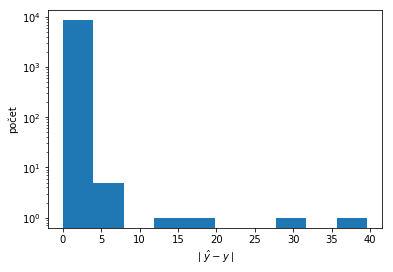

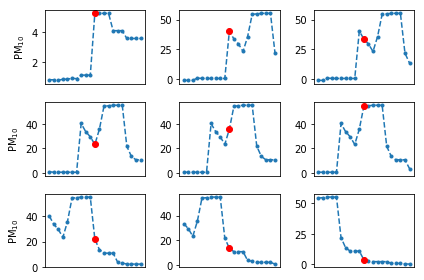

In [28]:
linear = linear_model.LinearRegression()
X_tr_trans, y_tr_trans = data.transform_dataset(X_tr, y_tr, best_window)
X_val_trans, y_val_trans = data.transform_dataset(X_val, y_val, best_window)
linear.fit(X_tr_trans, y_tr_trans)

y_pred = linear.predict(X_val_trans)
y_delta = np.abs(y_val_trans - y_pred)

plot.plot_delta_hist(y_delta)
plt.savefig('img/delta_histogram.svg')

_, bins = np.histogram(y_delta)
threshold = bins[1]

anomalies = y_delta > threshold
print('detekováno anomálií:', anomalies.sum())
plot.plot_anomalies(anomalies, y_val_trans)
plt.savefig('img/anomalies.svg')

## Testování

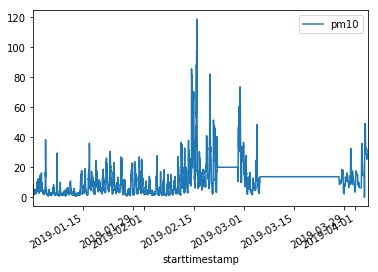

In [29]:
test_data.plot(y='pm10')
plt.savefig('img/test_data.svg')

detekováno anomálií v testovacích datech: 113


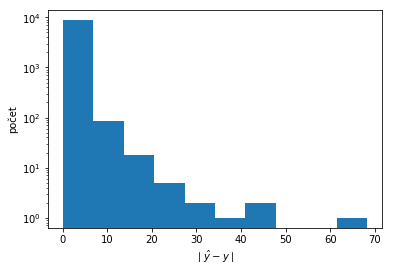

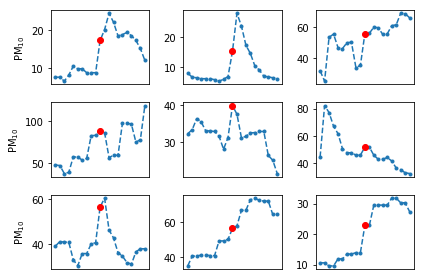

In [30]:
resampled_test_data = data.resample_data(test_data, period='15T')

X_tr = resampled_train_data[['pm10']].values[:-1]
y_tr = resampled_train_data[['pm10']].values[1:]
X_te = resampled_test_data[['pm10']].values[:-1]
y_te = resampled_test_data[['pm10']].values[1:]

linear = linear_model.LinearRegression()
X_tr_trans, y_tr_trans = data.transform_dataset(X_tr, y_tr, best_window)
X_te_trans, y_te_trans = data.transform_dataset(X_te, y_te, best_window)
linear.fit(X_tr_trans, y_tr_trans)

y_pred = linear.predict(X_te_trans)
y_delta = np.abs(y_te_trans - y_pred)

plot.plot_delta_hist(y_delta)
plt.savefig('img/test_delta_histogram.svg')

_, bins = np.histogram(y_delta)
threshold = bins[1]

anomalies = y_delta > threshold
print('detekováno anomálií v testovacích datech:', anomalies.sum())

np.random.seed(16)
index = np.arange(anomalies.shape[0])[anomalies.ravel()]
random_index = np.random.choice(index, size=9, replace=False)
random_anomalies = np.zeros_like(anomalies)
random_anomalies[random_index] = True

plot.plot_anomalies(random_anomalies, y_te_trans)
plt.savefig('img/test_anomalies.svg')

## Závěr